In [4]:
# pip install torch torch-geometric pandas numpy scikit-learn

In [5]:
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [12]:
# Load and preprocess data (reusing existing functions)
def load_and_preprocess_data(file_path, columns):
    df = (pd.read_csv(file_path, usecols=columns)
          .fillna("empty")
          .query("DevType != 'empty' and DevType != 'Other (please specify):'")
          .reset_index(drop=True))
    return df

def combine_skills(df, columns, new_column_name):
    df[new_column_name] = (df[columns]
                           .fillna('')
                           .agg(';'.join, axis=1)
                           .apply(lambda x: x.split(';') if x else []))
    return df

# Load and preprocess data
columns_finalized = ['ResponseId', 'DevType', 'LanguageHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'PlatformHaveWorkedWith',
                     'MiscTechHaveWorkedWith', 'WebframeHaveWorkedWith', 'DatabaseHaveWorkedWith']

df = load_and_preprocess_data("/kaggle/input/survey-results/survey_results_public.csv", columns_finalized)
df = combine_skills(df, ['LanguageHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'PlatformHaveWorkedWith',
                         'MiscTechHaveWorkedWith', 'WebframeHaveWorkedWith', 'DatabaseHaveWorkedWith'], 
                    'AllSkillsHaveWorkedWith')

# Filter out students
df_non_students = df.query("DevType != 'Student'").reset_index(drop=True)

# Prepare data for GNN
skills = df_non_students['AllSkillsHaveWorkedWith'].explode().unique()
skill_encoder = LabelEncoder().fit(skills)
dev_type_encoder = LabelEncoder().fit(df_non_students['DevType'])

# Define a fixed feature size
feature_size = 64

# Create node features
num_users = len(df_non_students)
num_skills = len(skills)
num_dev_types = len(dev_type_encoder.classes_)

user_features = torch.randn(num_users, feature_size)
skill_features = torch.randn(num_skills, feature_size)
dev_type_features = torch.randn(num_dev_types, feature_size)


# Create edges
user_skill_edges = []
user_dev_type_edges = []

for idx, row in df_non_students.iterrows():
    user_skills = skill_encoder.transform(row['AllSkillsHaveWorkedWith'])
    user_skill_edges.extend([(idx, skill_idx + num_users) for skill_idx in user_skills])
    user_dev_type_edges.append((idx, dev_type_encoder.transform([row['DevType']])[0] + num_users + num_skills))

# Combine all edges
edges = user_skill_edges + user_dev_type_edges
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


# Combine all node features
x = torch.cat([user_features, skill_features, dev_type_features], dim=0)



# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index)

# Define GNN model
# class GNNJobRecommender(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels, num_classes):
#         super(GNNJobRecommender, self).__init__()
#         self.conv1 = GCNConv(num_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, num_classes)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         return x

from torch_geometric.nn import GATConv

class GNNJobRecommender(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GNNJobRecommender, self).__init__()
        # 8 attention heads in the first layer
        self.conv1 = GATConv(num_features, hidden_channels, heads=8, dropout=0.6)
        # 1 attention head in the second layer
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

# Initialize model
model = GNNJobRecommender(num_features=feature_size, hidden_channels=32, num_classes=num_dev_types)

# Split data into train and test sets
train_mask = torch.zeros(num_users, dtype=torch.bool)
train_mask[:num_users-5000] = True
test_mask = ~train_mask

# Prepare labels
y = torch.tensor(dev_type_encoder.transform(df_non_students['DevType']))

# Training function
def train(data, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.nn.functional.cross_entropy(out[:num_users][train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    return loss

train_accuracies = []
test_accuracies = []

# Evaluation function
def test(data, model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[:num_users].argmax(dim=1)
    test_correct = pred[test_mask] == y[test_mask]
    test_acc = int(test_correct.sum()) / int(test_mask.sum())
    return test_acc

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(50):
    loss = train(data, model, optimizer)
    train_acc = test(data, model)  # You can use the test function to get train accuracy as well
    train_accuracies.append(train_acc)
    if epoch % 1 == 0:
        test_acc = test(data, model)
        test_accuracies.append(test_acc)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')
    
# Function to get job recommendations
def get_job_recommendations(user_idx, model, data, dev_type_encoder, top_n=5):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        user_probs = torch.nn.functional.softmax(out[user_idx], dim=0)
        top_indices = user_probs.argsort(descending=True)[:top_n]
        return dev_type_encoder.inverse_transform(top_indices.numpy())

# Create a boolean mask for test users
test_mask_np = test_mask.numpy()

# Example: Get top 5 job recommendations for a specific user in the test set
test_user_idx = np.where(test_mask_np)[0][0]
recommended_jobs = get_job_recommendations(test_user_idx, model, data, dev_type_encoder)
print(f"Top job recommendations for user {test_user_idx}: {recommended_jobs}")

# Calculate MRR for test set
def calculate_mrr(true_jobs, predicted_jobs):
    mrr = 0.0
    for true_job, pred_jobs in zip(true_jobs, predicted_jobs):
        try:
            rank = np.where(pred_jobs == true_job)[0][0] + 1
            mrr += 1 / rank
        except IndexError:
            continue
    return mrr / len(true_jobs)

Epoch: 000, Loss: 4.1544, Test Acc: 0.0676
Epoch: 001, Loss: 4.0788, Test Acc: 0.0850
Epoch: 002, Loss: 4.0057, Test Acc: 0.1102
Epoch: 003, Loss: 3.9212, Test Acc: 0.1374
Epoch: 004, Loss: 3.8479, Test Acc: 0.1606
Epoch: 005, Loss: 3.7882, Test Acc: 0.1770
Epoch: 006, Loss: 3.7277, Test Acc: 0.1950
Epoch: 007, Loss: 3.6916, Test Acc: 0.2114
Epoch: 008, Loss: 3.6403, Test Acc: 0.2292
Epoch: 009, Loss: 3.6050, Test Acc: 0.2488
Epoch: 010, Loss: 3.5790, Test Acc: 0.2632
Epoch: 011, Loss: 3.5417, Test Acc: 0.2740
Epoch: 012, Loss: 3.5206, Test Acc: 0.2858
Epoch: 013, Loss: 3.5047, Test Acc: 0.2986
Epoch: 014, Loss: 3.4852, Test Acc: 0.3080
Epoch: 015, Loss: 3.4702, Test Acc: 0.3156
Epoch: 016, Loss: 3.4620, Test Acc: 0.3232
Epoch: 017, Loss: 3.4452, Test Acc: 0.3258
Epoch: 018, Loss: 3.4341, Test Acc: 0.3310
Epoch: 019, Loss: 3.4165, Test Acc: 0.3324
Epoch: 020, Loss: 3.4070, Test Acc: 0.3308
Epoch: 021, Loss: 3.3849, Test Acc: 0.3284
Epoch: 022, Loss: 3.3653, Test Acc: 0.3284
Epoch: 023,

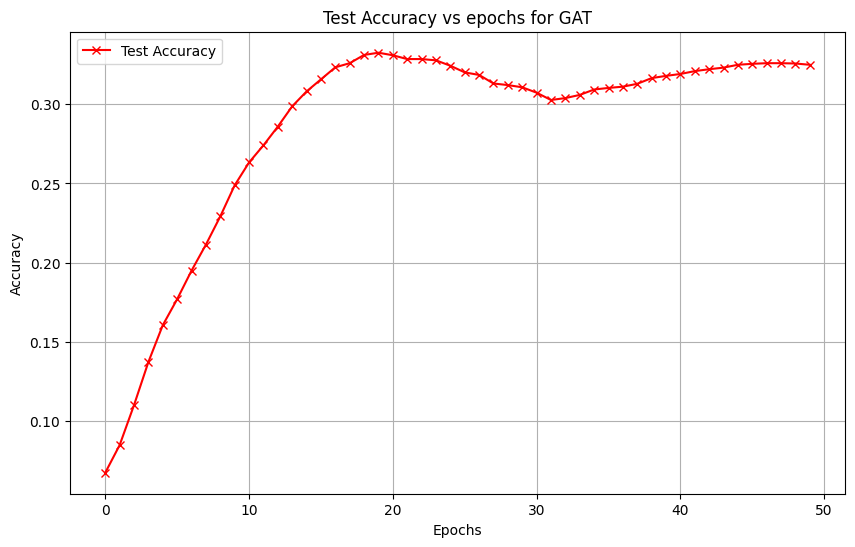

In [ ]:
import matplotlib.pyplot as plt

# Plotting the train vs test accuracy
plt.figure(figsize=(10, 6))
epochs = range(50)

# Train accuracy plot
# plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')

# Test accuracy plot
plt.plot(epochs, train_accuracies, label='Test Accuracy', color='red', marker='x')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs epochs for GAT')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [8]:
from tqdm import tqdm  # Ensure you have tqdm for progress bar

# Precompute the softmax probabilities for all users
def get_job_recommendations_batch(data, model):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        softmax_out = torch.nn.functional.softmax(out[:num_users], dim=1)  # Precompute softmax for all users
    return softmax_out

# Precompute predictions for all users at once
all_user_probs = get_job_recommendations_batch(data, model)

# Get top N job recommendations for a specific user
def get_top_n_jobs(user_probs, dev_type_encoder, top_n=5):
    top_indices = user_probs.argsort(descending=True)[:top_n]
    return dev_type_encoder.inverse_transform(top_indices.numpy())

# Precompute predicted jobs for all test users
true_jobs_test = df_non_students.loc[test_mask_np, 'DevType'].values
test_user_indices = np.where(test_mask_np)[0]
predicted_jobs_test = []
for user_idx in tqdm(test_user_indices):
    user_probs = all_user_probs[user_idx]
    recommended_jobs = get_top_n_jobs(user_probs, dev_type_encoder, top_n=10)
    predicted_jobs_test.append(recommended_jobs)

# Calculate MRR for the test set
mrr_score_test = calculate_mrr(true_jobs_test, predicted_jobs_test)
print(f'MRR Score on Test Set: {mrr_score_test}')

100%|██████████| 5000/5000 [00:00<00:00, 5268.69it/s]

MRR Score on Test Set: 0.4969627777777765


In [21]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

def load_and_preprocess_data(file_path, columns):
    """Load and preprocess the survey data."""
    df = pd.read_csv(file_path, usecols=columns)
    # Convert string columns to lists if they're semicolon-separated
    for col in columns:
        if col not in ['ResponseId', 'DevType']:
            df[col] = df[col].fillna('')
    df = df.dropna(subset=['DevType'])  # Ensure DevType is not null
    return df

def combine_skills(df, skill_columns, output_column):
    """Combine multiple skill columns into a single list."""
    def split_skills(x):
        skills = []
        for col in x:
            if pd.notna(col) and col:
                skills.extend([s.strip() for s in str(col).split(';') if s.strip()])
        return skills

    df[output_column] = df[skill_columns].apply(split_skills, axis=1)
    return df

def prepare_heterogeneous_data(df_non_students, feature_size=64):
    """Prepare heterogeneous graph data."""
    # Handle empty skill lists
    df_non_students = df_non_students[df_non_students['AllSkillsHaveWorkedWith'].apply(len) > 0].reset_index(drop=True)
    
    # Prepare encoders
    all_skills = set()
    for skills in df_non_students['AllSkillsHaveWorkedWith']:
        all_skills.update(skills)
    skills = np.array(list(all_skills))
    
    skill_encoder = LabelEncoder()
    skill_encoder.fit(skills)
    
    dev_type_encoder = LabelEncoder()
    dev_type_encoder.fit(df_non_students['DevType'])
    
    # Create HeteroData object
    data = HeteroData()
    
    # Add node features
    num_users = len(df_non_students)
    num_skills = len(skills)
    num_dev_types = len(dev_type_encoder.classes_)
    
    # Initialize features with normalization
    data['user'].x = torch.nn.functional.normalize(torch.randn(num_users, feature_size), p=2, dim=1)
    data['skill'].x = torch.nn.functional.normalize(torch.randn(num_skills, feature_size), p=2, dim=1)
    data['dev_type'].x = torch.nn.functional.normalize(torch.randn(num_dev_types, feature_size), p=2, dim=1)
    
    # Create edges
    user_skill_src = []
    user_skill_dst = []
    for idx, skills in enumerate(df_non_students['AllSkillsHaveWorkedWith']):
        if skills:  # Check if skills list is not empty
            skill_indices = skill_encoder.transform(skills)
            user_skill_src.extend([idx] * len(skill_indices))
            user_skill_dst.extend(skill_indices)
    
    dev_type_skill_src = []
    dev_type_skill_dst = []
    for dev_type_idx, dev_type in enumerate(dev_type_encoder.classes_):
        dev_type_mask = df_non_students['DevType'] == dev_type
        dev_type_users = df_non_students[dev_type_mask]
        if not dev_type_users.empty:
            dev_type_skills = []
            for skills in dev_type_users['AllSkillsHaveWorkedWith']:
                dev_type_skills.extend(skills)
            if dev_type_skills:
                skill_counts = pd.Series(dev_type_skills).value_counts()
                top_skills = skill_counts.nlargest(min(10, len(skill_counts))).index
                dev_type_skill_indices = skill_encoder.transform(top_skills)
                dev_type_skill_src.extend([dev_type_idx] * len(dev_type_skill_indices))
                dev_type_skill_dst.extend(dev_type_skill_indices)
    
    user_dev_type_src = list(range(len(df_non_students)))
    user_dev_type_dst = dev_type_encoder.transform(df_non_students['DevType'])
    
    # Convert to tensors and add edges to data object
    if user_skill_src:  # Only create edges if there are any
        data['user', 'has_skill', 'skill'].edge_index = torch.tensor([user_skill_src, user_skill_dst])
        data['skill', 'rev_has_skill', 'user'].edge_index = torch.tensor([user_skill_dst, user_skill_src])
    
    if dev_type_skill_src:  # Only create edges if there are any
        data['dev_type', 'requires_skill', 'skill'].edge_index = torch.tensor([dev_type_skill_src, dev_type_skill_dst])
        data['skill', 'rev_requires_skill', 'dev_type'].edge_index = torch.tensor([dev_type_skill_dst, dev_type_skill_src])
    
    data['user', 'has_type', 'dev_type'].edge_index = torch.tensor([user_dev_type_src, user_dev_type_dst])
    data['dev_type', 'rev_has_type', 'user'].edge_index = torch.tensor([user_dev_type_dst, user_dev_type_src])
    
    return data, skill_encoder, dev_type_encoder, df_non_students

import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, Linear
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# [Previous code remains the same until prepare_heterogeneous_data]

class ImprovedHGNNJobRecommender(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super().__init__()
        
        # First layer of convolutions
        self.conv1 = HeteroConv({
            ('user', 'has_skill', 'skill'): SAGEConv((-1, -1), hidden_channels),
            ('skill', 'rev_has_skill', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('dev_type', 'requires_skill', 'skill'): SAGEConv((-1, -1), hidden_channels),
            ('skill', 'rev_requires_skill', 'dev_type'): SAGEConv((-1, -1), hidden_channels),
            ('user', 'has_type', 'dev_type'): SAGEConv((-1, -1), hidden_channels),
            ('dev_type', 'rev_has_type', 'user'): SAGEConv((-1, -1), hidden_channels),
        })
        
        # Second layer of convolutions
        self.conv2 = HeteroConv({
            ('user', 'has_skill', 'skill'): SAGEConv((-1, -1), hidden_channels),
            ('skill', 'rev_has_skill', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('dev_type', 'requires_skill', 'skill'): SAGEConv((-1, -1), hidden_channels),
            ('skill', 'rev_requires_skill', 'dev_type'): SAGEConv((-1, -1), hidden_channels),
            ('user', 'has_type', 'dev_type'): SAGEConv((-1, -1), hidden_channels),
            ('dev_type', 'rev_has_type', 'user'): SAGEConv((-1, -1), hidden_channels),
        })
        
        # Output layers
        self.linear1 = Linear(hidden_channels, hidden_channels)
        self.linear2 = Linear(hidden_channels, num_classes)
        
    def forward(self, x_dict, edge_index_dict):
        # First conv layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        
        # Second conv layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        
        # Get user embeddings and pass through final layers
        out = x_dict['user']
        out = self.linear1(out).relu()
        out = self.linear2(out)
        return out

test_accuracies = []

def train_with_early_stopping(model, data, optimizer, num_users, train_mask, val_mask, test_mask, y, 
                              patience=10, max_epochs=50):
    """Train the model with early stopping."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)
    y = y.to(device)
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)
    test_mask = test_mask.to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data.x_dict, data.edge_index_dict)
            val_loss = criterion(out[val_mask], y[val_mask])
            
            # Calculate and log test accuracy
            test_out = out[test_mask]
            test_preds = test_out.argmax(dim=1)
            test_acc = accuracy_score(y[test_mask].cpu(), test_preds.cpu())
            test_accuracies.append(test_acc)
            
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

def get_job_recommendations_batch(model, data):
    """Get job recommendations for all users in batch."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)
    
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        probs = torch.softmax(out, dim=1)
    return probs.cpu().numpy()

def get_top_n_jobs(user_probs, dev_type_encoder, top_n=10):
    """Get top N job recommendations for a user."""
    job_indices = np.argsort(user_probs)[::-1][:top_n]
    return dev_type_encoder.inverse_transform(job_indices)

def calculate_mrr(true_jobs, predicted_jobs_lists):
    """Calculate Mean Reciprocal Rank."""
    reciprocal_ranks = []
    for true_job, pred_jobs in zip(true_jobs, predicted_jobs_lists):
        try:
            rank = pred_jobs.tolist().index(true_job) + 1
            reciprocal_ranks.append(1.0 / rank)
        except ValueError:
            reciprocal_ranks.append(0.0)
    return np.mean(reciprocal_ranks)

if __name__ == "__main__":
    # Load and preprocess data
    columns_finalized = ['ResponseId', 'DevType', 'LanguageHaveWorkedWith', 'ToolsTechHaveWorkedWith', 
                        'PlatformHaveWorkedWith', 'MiscTechHaveWorkedWith', 'WebframeHaveWorkedWith', 
                        'DatabaseHaveWorkedWith']
    
    df = load_and_preprocess_data("/kaggle/input/survey-results/survey_results_public.csv", columns_finalized)
    df = combine_skills(df, ['LanguageHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'PlatformHaveWorkedWith',
                            'MiscTechHaveWorkedWith', 'WebframeHaveWorkedWith', 'DatabaseHaveWorkedWith'], 
                       'AllSkillsHaveWorkedWith')
    
    # Filter out students and empty skills
    df_non_students = df.query("DevType != 'Student'").reset_index(drop=True)
    
    # Prepare data
    data, skill_encoder, dev_type_encoder, df_non_students = prepare_heterogeneous_data(df_non_students)
    
    # Prepare masks
    num_users = len(df_non_students)
    indices = np.random.permutation(num_users)
    train_idx = indices[:int(0.7*num_users)]
    val_idx = indices[int(0.7*num_users):int(0.85*num_users)]
    test_idx = indices[int(0.85*num_users):]
    
    train_mask = torch.zeros(num_users, dtype=torch.bool)
    val_mask = torch.zeros(num_users, dtype=torch.bool)
    test_mask = torch.zeros(num_users, dtype=torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    # Prepare labels
    y = torch.tensor(dev_type_encoder.transform(df_non_students['DevType'].values))
    
    # Initialize model
    num_classes = len(dev_type_encoder.classes_)
    model = ImprovedHGNNJobRecommender(hidden_channels=32, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.005)
    
    # Train model
    model = train_with_early_stopping(model, data, optimizer, num_users, train_mask, val_mask,test_mask, y)
    
    # Get recommendations and evaluate
    all_user_probs = get_job_recommendations_batch(model, data)
    
    # Evaluate on test set
    test_mask_np = test_mask.numpy()
    true_jobs_test = df_non_students.loc[test_mask_np, 'DevType'].values
    test_user_indices = np.where(test_mask_np)[0]
    
    predicted_jobs_test = []
    for user_idx in tqdm(test_user_indices, desc="Generating predictions"):
        user_probs = all_user_probs[user_idx]
        recommended_jobs = get_top_n_jobs(user_probs, dev_type_encoder, top_n=10)
        predicted_jobs_test.append(recommended_jobs)
    
    # Calculate and print MRR
    mrr_score_test = calculate_mrr(true_jobs_test, predicted_jobs_test)
    print(f'MRR Score on Test Set: {mrr_score_test}')
    
    # Print some example recommendations
    print("\nExample Recommendations:")
    for i in range(min(5, len(test_user_indices))):
        user_idx = test_user_indices[i]
        true_job = df_non_students.loc[user_idx, 'DevType']
        recommendations = predicted_jobs_test[i]
        print(f"\nUser {i+1}")
        print(f"True Job: {true_job}")
        print(f"Top 5 Recommendations: {', '.join(recommendations[:5])}")

Epoch 010, Train Loss: 3.4652, Val Loss: 3.4590, Test Acc: 0.0133
Epoch 020, Train Loss: 3.3852, Val Loss: 3.3721, Test Acc: 0.1975
Epoch 030, Train Loss: 3.2115, Val Loss: 3.1816, Test Acc: 0.5231
Epoch 040, Train Loss: 2.8242, Val Loss: 2.7617, Test Acc: 0.5231
Epoch 050, Train Loss: 2.1889, Val Loss: 2.1147, Test Acc: 0.5231


Generating predictions: 100%|██████████| 7903/7903 [00:01<00:00, 7602.57it/s]

MRR Score on Test Set: 0.5799092769673562

Example Recommendations:

User 1
True Job: Developer, full-stack
Top 5 Recommendations: Developer, full-stack, Developer, back-end, Developer, front-end, Developer, desktop or enterprise applications, Marketing or sales professional

User 2
True Job: Developer Experience
Top 5 Recommendations: Developer, back-end, Developer, full-stack, Developer, front-end, Developer, desktop or enterprise applications, Other (please specify):

User 3
True Job: Developer, full-stack
Top 5 Recommendations: Developer, full-stack, Developer, back-end, Developer, desktop or enterprise applications, Developer, front-end, Marketing or sales professional

User 4
True Job: Developer, front-end
Top 5 Recommendations: Developer, back-end, Developer, full-stack, Developer, front-end, Developer, desktop or enterprise applications, Other (please specify):

User 5
True Job: Developer, full-stack
Top 5 Recommendations: Developer, full-stack, Developer, back-end, Developer, 

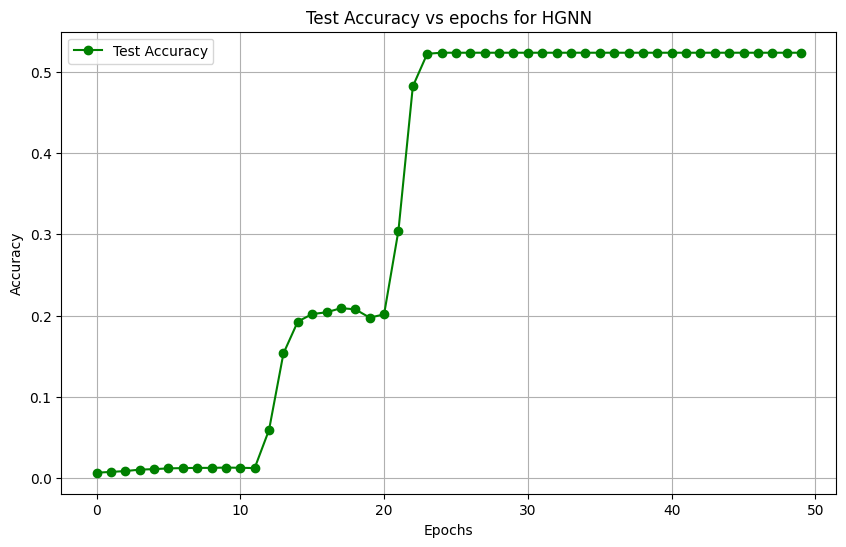

In [29]:
import matplotlib.pyplot as plt

# Plotting the train vs test accuracy
plt.figure(figsize=(10, 6))
epochs = range(50)

# Train accuracy plot
# plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')

# Test accuracy plot
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green', marker='o')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs epochs for HGNN')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [43]:
def recommend_jobs_for_students(df, model, data, dev_type_encoder, skill_encoder, feature_size=64):
    """
    Recommend jobs for students based on their skills using the trained model.
    
    Args:
        df: Original DataFrame containing all data
        model: Trained HGNNJobRecommender model
        data: HeteroData object used for training
        dev_type_encoder: Fitted LabelEncoder for dev types
        skill_encoder: Fitted LabelEncoder for skills
        feature_size: Size of feature vectors (default: 64)
    
    Returns:
        DataFrame with student data and job recommendations
    """
    # Filter students
    df_students = df.query("DevType == 'Student'").reset_index(drop=True)
    
    if len(df_students) == 0:
        return df_students
    
    # Create feature vectors for students
    num_students = len(df_students)
    student_features = torch.nn.functional.normalize(torch.randn(num_students, feature_size), p=2, dim=1)
    
    # Create student-skill edges
    student_skill_src = []
    student_skill_dst = []
    
    for idx, skills in enumerate(df_students['AllSkillsHaveWorkedWith']):
        if skills:  # Check if skills list is not empty
            # Filter only known skills (those in the encoder)
            known_skills = [skill for skill in skills if skill in skill_encoder.classes_]
            if known_skills:
                skill_indices = skill_encoder.transform(known_skills)
                student_skill_src.extend([idx] * len(skill_indices))
                student_skill_dst.extend(skill_indices)
    
    # Create temporary HeteroData object for students
    student_data = HeteroData()
    
    # Copy existing skill and dev_type data
    student_data['skill'].x = data['skill'].x
    student_data['dev_type'].x = data['dev_type'].x
    
    # Add student features and edges
    student_data['user'].x = student_features
    
    if student_skill_src:  # Only create edges if there are any
        student_data['user', 'has_skill', 'skill'].edge_index = torch.tensor([student_skill_src, student_skill_dst])
        student_data['skill', 'rev_has_skill', 'user'].edge_index = torch.tensor([student_skill_dst, student_skill_src])
    
    # Copy other relevant edges from training data
    student_data['dev_type', 'requires_skill', 'skill'].edge_index = data['dev_type', 'requires_skill', 'skill'].edge_index
    student_data['skill', 'rev_requires_skill', 'dev_type'].edge_index = data['skill', 'rev_requires_skill', 'dev_type'].edge_index
    
    # Get recommendations
    model.eval()
    with torch.no_grad():
        all_student_probs = get_job_recommendations_batch(model, student_data)
    
    # Get top recommendations for each student
    recommendations = []
    recommendation_probs = []
    for idx in range(len(df_students)):
        student_probs = all_student_probs[idx]
        # Get indices of top 5 probabilities
        top_indices = torch.argsort(student_probs, descending=True)[:5]
        # Get the actual probability values
        top_probs = student_probs[top_indices].tolist()
        # Get the job titles
        top_jobs = [dev_type_encoder.inverse_transform([i.item()])[0] for i in top_indices]
        
        recommendations.append(top_jobs)
        recommendation_probs.append(top_probs)
    
    # Add recommendations to DataFrame
    df_students['RecommendedJobs'] = recommendations
    df_students['RecommendationConfidence'] = recommendation_probs
    
    return df_students

# Example usage after training the model:
def add_student_recommendations(df, model, data, dev_type_encoder, skill_encoder):
    """
    Add job recommendations for students to the original DataFrame.
    """
    # Get recommendations for students
    df_students_with_recommendations = recommend_jobs_for_students(
        df, model, data, dev_type_encoder, skill_encoder
    )
    
    # Combine with non-student data
    df_non_students = df.query("DevType != 'Student'").reset_index(drop=True)
    df_non_students['RecommendedJobs'] = None
    df_non_students['RecommendationConfidence'] = None
    
    # Concatenate and sort by original index if needed
    df_combined = pd.concat([df_non_students, df_students_with_recommendations], ignore_index=True)
    
    return df_combined

# Usage in main:
if __name__ == "__main__":    
    # After training the model, add recommendations for students
    df_with_recommendations = add_student_recommendations(
        df, model, data, dev_type_encoder, skill_encoder
    )
    
    # Example of printing recommendations for the first few students
    print("\nStudent Job Recommendations:")
    student_recommendations = df_with_recommendations[
        df_with_recommendations['DevType'] == 'Student'
    ][['RecommendedJobs', 'RecommendationConfidence']].head()
    
    for idx, row in student_recommendations.iterrows():
        print(f"\nStudent {idx + 1}")
        for job, confidence in zip(row['RecommendedJobs'], row['RecommendationConfidence']):
            print(f"- {job}: {confidence:.3f}")


Student Job Recommendations:

Student 54344
- Developer, full-stack: 0.115
- Developer, back-end: 0.112
- Engineering manager: 0.064
- Developer, desktop or enterprise applications: 0.058
- Developer, front-end: 0.056

Student 54345
- Developer, full-stack: 0.191
- Developer, front-end: 0.123
- Developer, back-end: 0.104
- Developer, desktop or enterprise applications: 0.051
- Engineering manager: 0.042

Student 54346
- Developer, front-end: 0.158
- Developer, full-stack: 0.130
- Developer, back-end: 0.114
- Developer, desktop or enterprise applications: 0.056
- Engineering manager: 0.046

Student 54347
- Developer, full-stack: 0.132
- Developer, back-end: 0.103
- Engineering manager: 0.069
- Developer, front-end: 0.064
- Developer, desktop or enterprise applications: 0.062

Student 54348
- Developer, full-stack: 0.134
- Developer, back-end: 0.098
- Developer, front-end: 0.061
- Developer, desktop or enterprise applications: 0.056
- Engineering manager: 0.052


In [ ]:
df_with_recommendations[df_with_recommendations['DevType']=='Student']['RecommendedJobs'].apply(lambda x: x[0]).value_counts()